In [1]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, process
from spectrometer.process import decaying_sinus

cm = 1 / 2.54

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
file = Path(
    "../data/20230822-091753-Water-1H-single_90_degree_pulse,length=9us,delay=25us,record_length=10000,sample_rate=320000,probe=andrew.fid"
)
fid = FID1D.from_file(file)

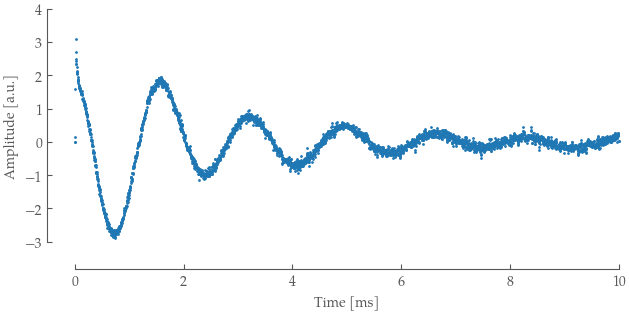

In [3]:
# Plot raw data
fig = fid.plot(
    figsize=(16.0 * cm, 8.0 * cm)  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
fig.savefig("fid_raw.pdf")

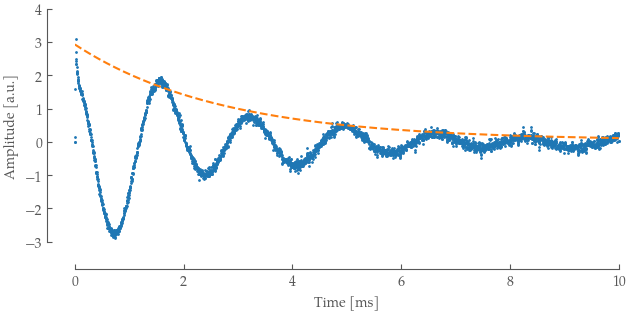

In [4]:
# Try fitting the envelope
try:
    # Plot raw data
    fig = fid.plot(
        figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    )
    axes = fig.axes[0]

    envelope = np.abs(sps.hilbert(fid.real))
    fit_exp_decay = process.exp_decay.fit(fid.ms_scale, envelope)
    ms_scale_fine = np.linspace(
        fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10
    )
    axes.plot(
        ms_scale_fine,
        fit_exp_decay(ms_scale_fine),
        linestyle="--",
    )

    # Try fitting the absolute directly
    fit_abs = process.exp_decay.fit(fid.ms_scale, fid.absolute)
    axes.plot(
        ms_scale_fine,
        fit_abs(ms_scale_fine),
        linestyle=":",
    )
except RuntimeError:
    pass

fig.savefig("fid_envelope_fit.pdf")

Amplitude: 3.1706557340566004
Frequency: 0.5892140431027253
Phase: 2.02247888878803
Offset: -0.020663079016846702
Lambda: 0.3928068920346734


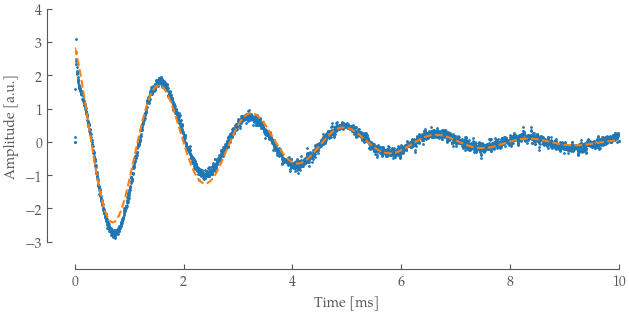

In [5]:
# Try to plot simple least squares fit for a decaying sinusoid
decaying_sinus_fit = decaying_sinus.fit(fid.ms_scale, fid.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)
print(decaying_sinus_fit)

# Plot raw
fig = fid.plot(figsize=(16 * cm, 8 * cm))  # Wide Layout: ~16cm, Margin Layout: 10.7cm

# Plot fit
fig.axes[0].plot(
    ms_scale_fine,
    decaying_sinus_fit(ms_scale_fine),
    linestyle="--",
)

fig.savefig("fid_sine_fit.pdf")

Phase Shift: 37.15743750000004


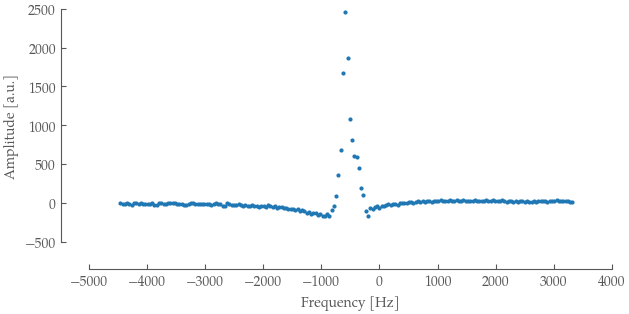

In [6]:
# Spectrum
spectrum, p0 = fid.spectrum()
print(f"Phase Shift: {p0}")

peak_spectrum = spectrum.crop_around(spectrum.max_peak, 200)
peak_fig = peak_spectrum.hz.plot(figsize=(16 * cm, 8 * cm))

peak_fig.savefig("fft_raw.pdf")

Amplitude: 2505.992379744465
Gamma: 58.829497461170995 Hz
Full Width at Half Maximum: 117.65899492234199 Hz
T2* is thus: 2.705359555330925 ms
Position: -576.7271116458904 Hz


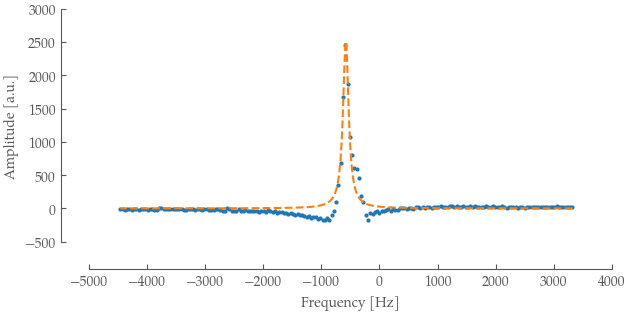

In [7]:
lorentz = peak_spectrum.hz.fit_lorentz()
hz_scale_fine = np.linspace(
    peak_spectrum.hz.limits[0], peak_spectrum.hz.limits[1], peak_spectrum.hz.size * 10
)

fig = peak_spectrum.hz.plot(figsize=(16 * cm, 8 * cm))
fig.axes[0].plot(hz_scale_fine, lorentz(hz_scale_fine), linestyle="--")

print(f"Amplitude: {lorentz.amplitude}")
print(f"Gamma: {lorentz.gamma} Hz")
print(f"Full Width at Half Maximum: {lorentz.fwhm} Hz")
print(f"T2* is thus: {1000/(np.pi * lorentz.fwhm)} ms")
print(f"Position: {lorentz.position} Hz")

fig.savefig("fft_fit.pdf")

[Peak(location=99.0, amplitude=2495.631569125756, fwhm=3.0298339473450486, signal_strength=5991.04345703125, other_parameters=<generator object Spectrum1D.fit.<locals>.<listcomp>.<genexpr> at 0x7f79e969c860>)]


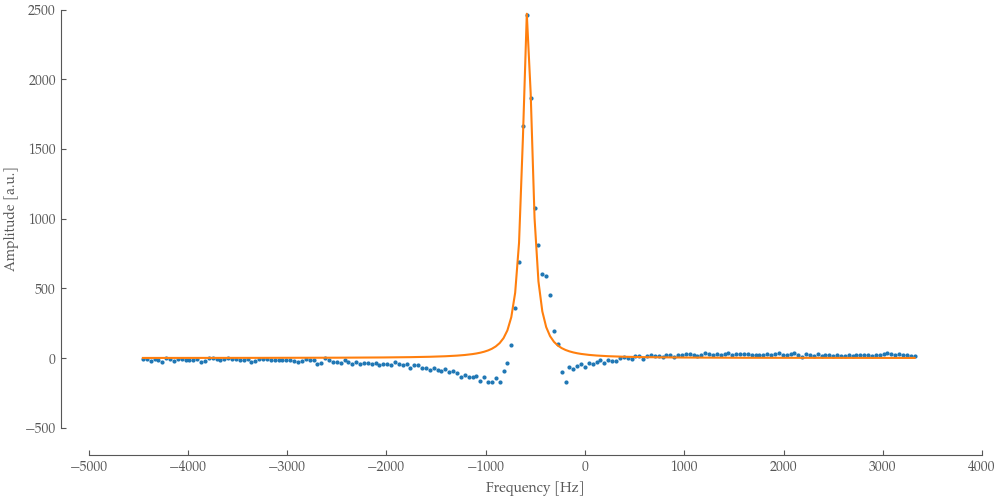

In [8]:
peaks = peak_spectrum.ppm.peaks()
fitted_spectrum, peaks = peak_spectrum.hz.fit()

fig = peak_spectrum.hz.plot()
fig.axes[0].plot(peak_spectrum.hz.scale, fitted_spectrum)
print(peaks)